In [ ]:
import os # for accessing files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image #PIL-> pillow library used for image processing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from imgaug import augmenters as iaa
import ntpath
import random


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#extracting the compressed dataset
from zipfile import ZipFile
dataset='/content/drive/MyDrive/dep/car data.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('the dataset is extracted')

the dataset is extracted


In [ ]:
datadir = 'data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\car simulator\data\IMG\center_2025_01_08_19...,D:\car simulator\data\IMG\left_2025_01_08_19_...,D:\car simulator\data\IMG\right_2025_01_08_19...,0.0,0.0,0.0,0.000081
1,D:\car simulator\data\IMG\center_2025_01_08_19...,D:\car simulator\data\IMG\left_2025_01_08_19_...,D:\car simulator\data\IMG\right_2025_01_08_19...,0.0,0.0,0.0,0.000081
2,D:\car simulator\data\IMG\center_2025_01_08_19...,D:\car simulator\data\IMG\left_2025_01_08_19_...,D:\car simulator\data\IMG\right_2025_01_08_19...,0.0,0.0,0.0,0.000080
3,D:\car simulator\data\IMG\center_2025_01_08_19...,D:\car simulator\data\IMG\left_2025_01_08_19_...,D:\car simulator\data\IMG\right_2025_01_08_19...,0.0,0.0,0.0,0.000078
4,D:\car simulator\data\IMG\center_2025_01_08_19...,D:\car simulator\data\IMG\left_2025_01_08_19_...,D:\car simulator\data\IMG\right_2025_01_08_19...,0.0,0.0,0.0,0.000078


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2025_01_08_19_50_09_940.jpg,left_2025_01_08_19_50_09_940.jpg,right_2025_01_08_19_50_09_940.jpg,0.0,0.0,0.0,0.000081
1,center_2025_01_08_19_50_10_047.jpg,left_2025_01_08_19_50_10_047.jpg,right_2025_01_08_19_50_10_047.jpg,0.0,0.0,0.0,0.000081
2,center_2025_01_08_19_50_10_152.jpg,left_2025_01_08_19_50_10_152.jpg,right_2025_01_08_19_50_10_152.jpg,0.0,0.0,0.0,0.000080
3,center_2025_01_08_19_50_10_256.jpg,left_2025_01_08_19_50_10_256.jpg,right_2025_01_08_19_50_10_256.jpg,0.0,0.0,0.0,0.000078
4,center_2025_01_08_19_50_10_358.jpg,left_2025_01_08_19_50_10_358.jpg,right_2025_01_08_19_50_10_358.jpg,0.0,0.0,0.0,0.000078


In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))




In [ ]:
print('total data:', len(data))
print(data.shape)

total data: 3085
(3085, 7)


In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 1937
remaining: 1148


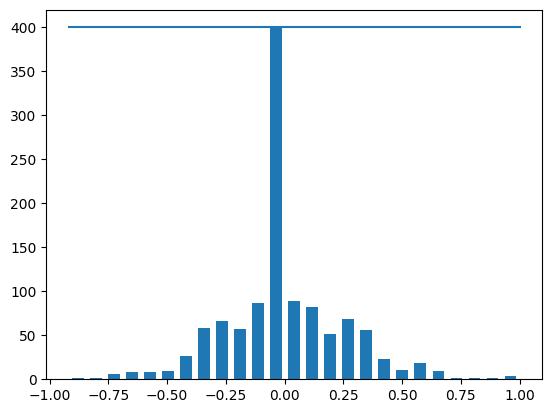

In [ ]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))



In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [ ]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)


<ipython-input-10-ec36c73ac642>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-10-ec36c73ac642>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
<ipython-input-10-ec36c73ac642>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3])+0.15)
<ipython-input-10-ec36c73ac642>:14:

In [ ]:
len(image_paths)

3444

In [ ]:
len(steerings)

3444

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 2755
Valid Samples: 689


Text(0.5, 1.0, 'Validation set')

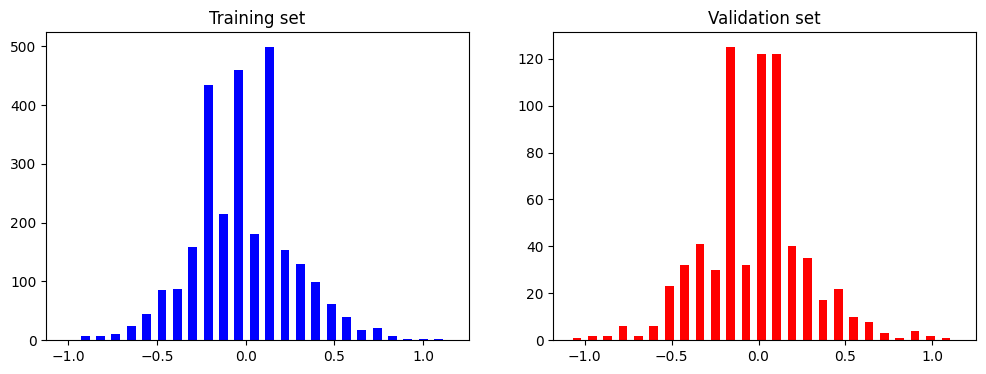

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

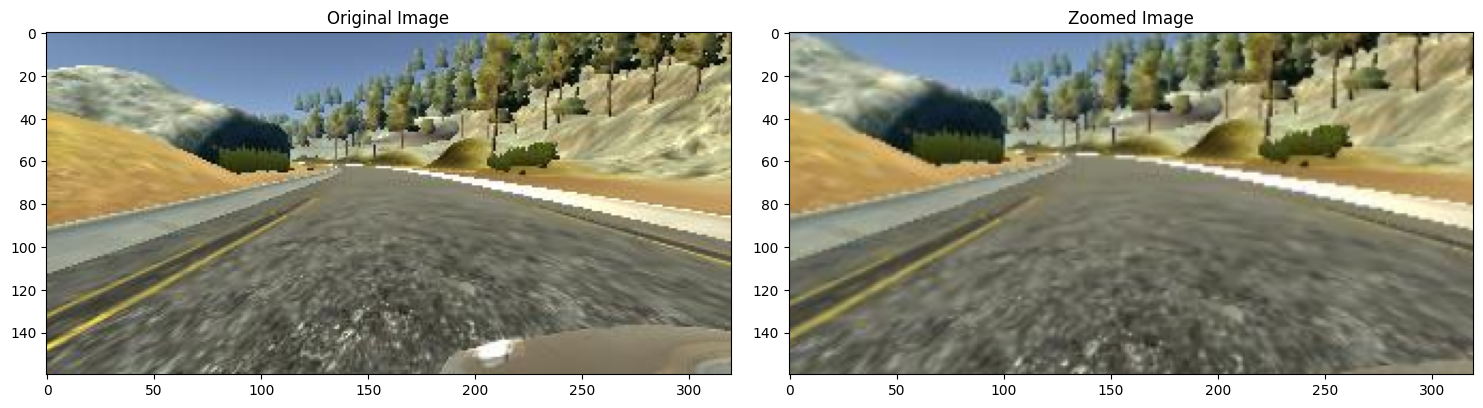

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image


image = image_paths[random.randint(0, 1000)]
original_image = mimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


Text(0.5, 1.0, 'Panned Image')

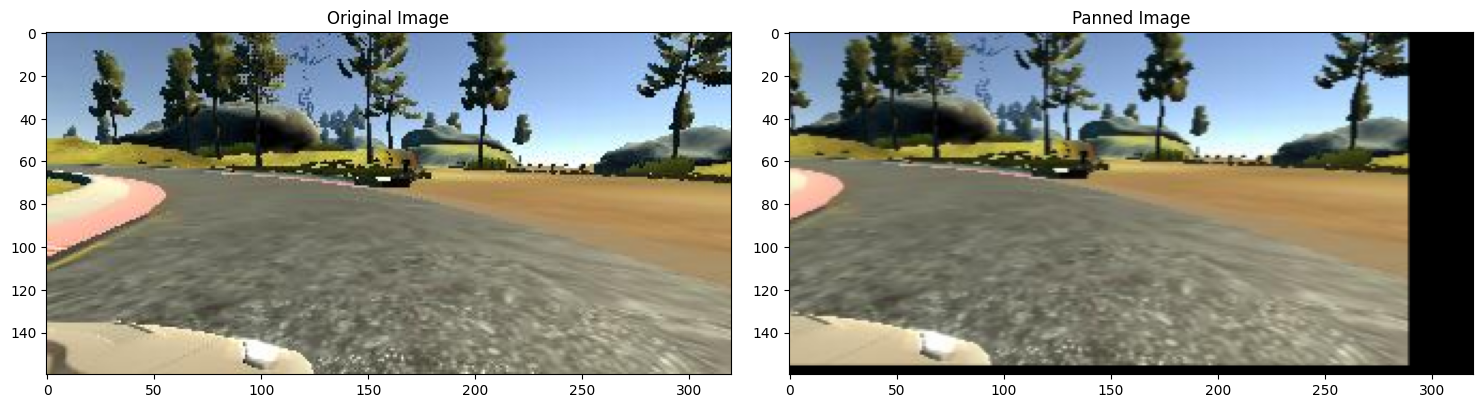

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

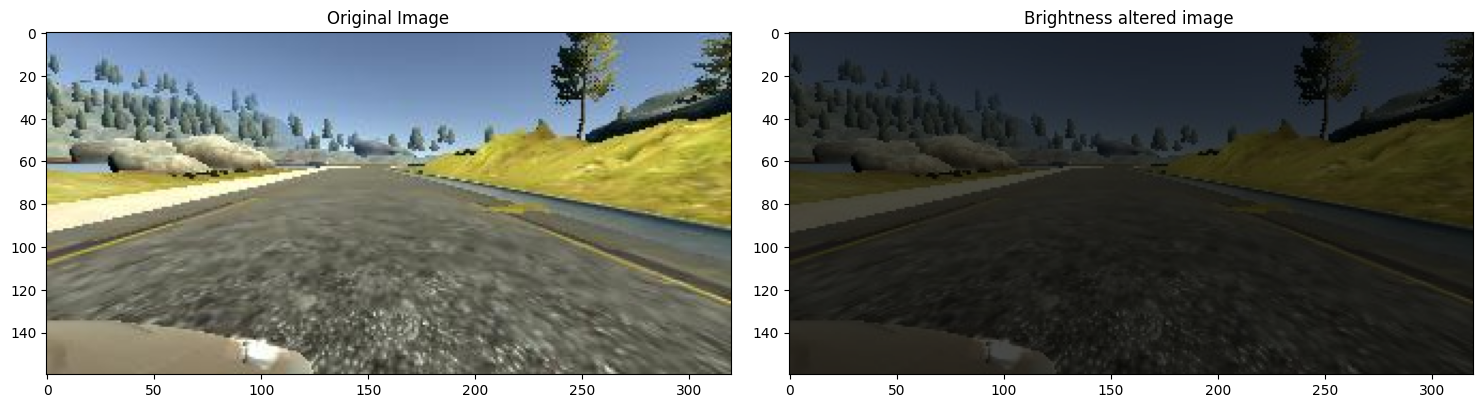

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)


fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15')

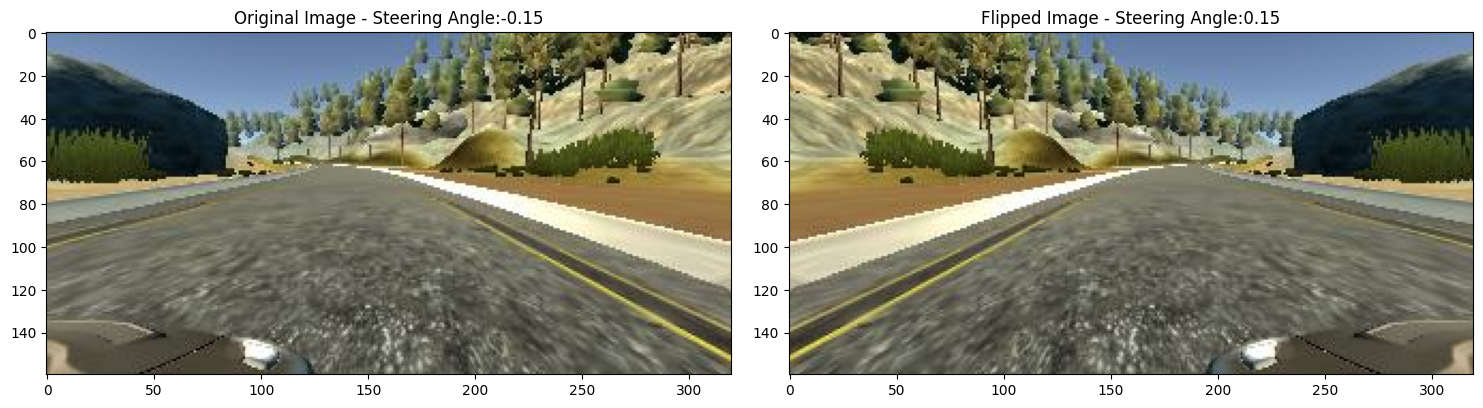

In [ ]:

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [ ]:
# We only need to change the random_augment function
def random_augment(image, steering_angle):
    image = mimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [ ]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [ ]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

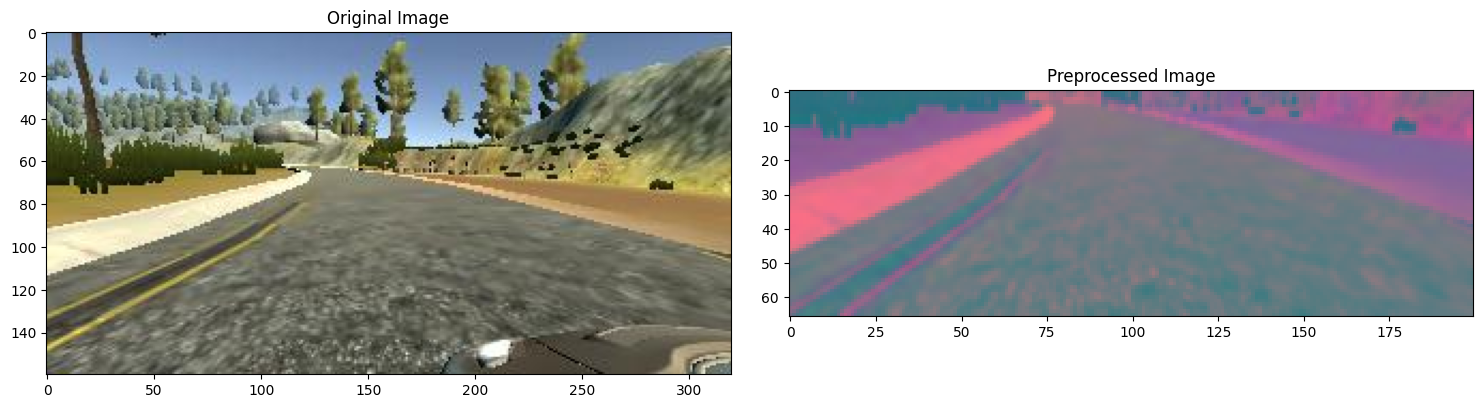

In [ ]:
image = image_paths[100]
original_image = mimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
def nvidia_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(keras.layers.Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(keras.layers.Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(keras.layers.Conv2D(64, (5, 5), activation='elu'))
  # model.add(keras.layers.Conv2D(64, (3,3), activation='elu'))
#   model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(100, activation = 'elu'))
#   model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.Dense(50, activation = 'elu'))
#   model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.Dense(10, activation = 'elu'))
#   model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model




In [ ]:
model=nvidia_model()
print(model.summary())

In [ ]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                    steps_per_epoch=300,
                    epochs=30,
                    validation_data=batch_generator(X_valid, y_valid, 100, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle = 1)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - loss: 0.0983 - val_loss: 0.1679
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - loss: 0.1048 - val_loss: 0.0873
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - loss: 0.1009 - val_loss: 0.1177
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - loss: 0.1135 - val_loss: 0.1546
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - loss: 0.1038 - val_loss: 0.1228
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - loss: 0.1120 - val_loss: 0.0850
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - loss: 0.1033 - val_loss: 0.1222
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - loss: 0.0894 - val_loss: 0.0893
Epoch 9/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - loss: 0.0838 - val_loss: 0.0893
Epoch 10/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - loss: 0.0862 - val_loss: 0.0906
Epoch 11/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - loss: 0.0818 - val_loss: 0.0850
Epoch 12/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 

Text(0.5, 0, 'Epoch')

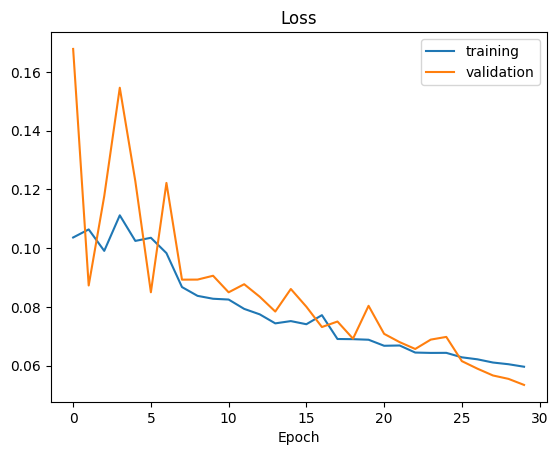

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
input_center_image = input('path of the image to be pedicted: ')
input_center_image = cv2.imread(input_center_image)
input_left_image = input('path of the image to be pedicted: ')
input_left_image = cv2.imread(input_left_image)
input_right_image = input('path of the image to be pedicted: ')
input_right_image = cv2.imread(input_right_image)


center_image_pp = img_preprocess(input_center_image)
left_image_pp = img_preprocess(input_left_image)
right_image_pp = img_preprocess(input_right_image)

image1_array = np.array(center_image_pp)
image2_array = np.array(left_image_pp)
image3_array = np.array(right_image_pp)

image_list = [image1_array, image2_array, image3_array]

input_dr=np.array(image_list)
input_image_reshaped = input_dr.reshape(3, 66, 200, 3)



input_prediction=model.predict(input_image_reshaped)

print(input_prediction)



path of the image to be pedicted: /content/drive/MyDrive/data/center_2025_01_08_19_50_10_664.jpg
path of the image to be pedicted: /content/drive/MyDrive/data/left_2025_01_08_19_50_10_664.jpg
path of the image to be pedicted: /content/drive/MyDrive/data/right_2025_01_08_19_50_10_664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
[[-55.289948]
 [-50.236095]
 [-54.125946]]
